In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as appl
from sklearn.model_selection import train_test_split
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from keras import callbacks  
from keras.models import load_model
from keras.utils import np_utils

In [3]:
load_path = 'E:/VA/onehandtwohand/128/105words_DSLR_results/'

In [6]:
# model

# model_name1 = 'InceptionResNetV2'
# model_name1 = '4layer'

#model_name2 = 'VGG16'
# model_name1 = 'DenseNet121'
# model_name1 = 'InceptionV3'

In [7]:
model_name1 = 'densenet121_lr0.00001_105words_dslr128'
# #load saved history
history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()


loaded


In [11]:
model_name2 = 'VGG19_lr0.00001_105words_dslr128'
# #load saved history
history_const2=np.load(load_path+model_name2+'_history.npy',allow_pickle='TRUE').item()


Plots


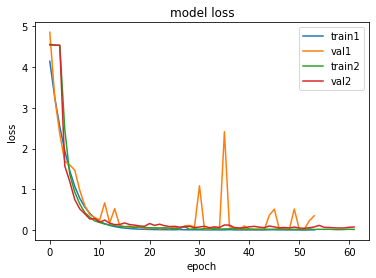

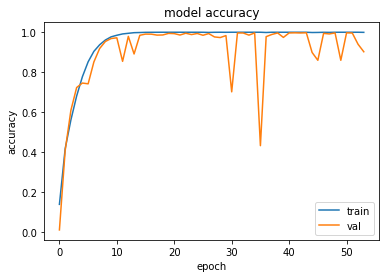

In [17]:
print('Plots')
plt.plot(history_const['loss'])
plt.plot(history_const['val_loss'])
plt.plot(history_const2['loss'])
plt.plot(history_const2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train1', 'val1','train2', 'val2'], loc='upper right')
# plt.savefig('F:/VA/onehandtwohand/26words_DSLR_results/'+model_name1+'_loss.png')
# plt.savefig(load_path+model_name1+'_loss.png')
plt.show()
plt.plot(history_const['accuracy'])
plt.plot(history_const['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
# plt.savefig(load_path+model_name1+'_accuracy.png')
plt.show()

In [17]:
print('Confusion matrix')
Y_pred = model1.predict(X_new)
y_pred = np.argmax(Y_pred, axis=1)
y_test1 = np.argmax(y_new, axis=1)

cm=metrics.confusion_matrix(y_test1, y_pred)


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
a4_dims = (200, 100)
fig,ax= plt.subplots(figsize=a4_dims)
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax,  linewidth=.5);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(CATEGORIES)
ax.set_yticklabels(CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig(load_path+model_name1+'_cm.png',bbox_inches='tight')
plt.show()


Confusion matrix
91/91 [==============================] - 5s 31ms/step


In [ ]:
#PLot fractional incorrect misclassifications

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(np.arange(cat_len), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(cat_len), CATEGORIES)
plt.savefig(load_path+model_name1+'_incorrect_percentage.png',bbox_inches='tight')
plt.show()

In [ ]:
#CHECK RANDOM IMAGES FROM TESTED DATA WHETHER RIGHT OR WRONG

i = random.randint(1,cat_len)
plt.imshow(X_new[i,:,:,2]) 
print("Predicted Label: ", CATEGORIES[int(y_pred[i])])
print("True Label: ", CATEGORIES[int(y_test1[i])])

# Colourful mediapipe testing with VA_create_3.0

In [18]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def landmarks(img,results):
      
# hands
    for hand_landmarks in results.multi_hand_landmarks:

        mp_drawing.draw_landmarks(
          img,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())

In [19]:
## For veryyyyyyyy beautiful webcam input:

cap = cv2.VideoCapture(0)
org = (20, 20)  
org1 = (310, 20) 
fontScale = 0.65  
font = cv2.FONT_HERSHEY_SIMPLEX
# Blue color in BGR
color = (130, 0, 0)  
# Line thickness of 2 px
thickness = 1 
thickness1 = -1
start_point = (0,0)
end_point = (480,30)
color1 = (255, 255, 255)  

with mp_hands.Hands(static_image_mode=False,max_num_hands=1,min_detection_confidence=0.5) as hands:
    while cap.isOpened():
        #image from feeder
        r, img_array = cap.read()
        img_array = cv2.flip(img_array, 1)
        img_array = img_array[:, 80:560, :]
        #to show
        results = hands.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        
        
        
        if not results.multi_hand_landmarks:  # exclude saving no hands
            continue
        landmarks(img_array, results)
        # to predict
        img = np.zeros([480,480,3],dtype=np.uint8)
        img.fill(255) 
        landmarks(img,results) # from function
        
        # for prediction
        IMG_SIZE=128
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        X = X.astype('float32')
        X /= 255
        X = np.array(X)
        Y = model1.predict(X,verbose=0)
        #to dhoe
        if np.max(Y)>0.2:
            # for display
            image = cv2.rectangle(img, start_point, end_point, color1, thickness1)
            image = cv2.rectangle(image, (0,30), (480,30), color, 2)
#             image = cv2.putText(image,"Prediction: "+ CATEGORIES[np.argmax(Y)], org, font, 
#                    fontScale, color, thickness, cv2.LINE_AA)
            image = cv2.putText(image, CATEGORIES[np.argmax(Y)], org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            image = cv2.putText(image,"Accuracy: "+ "%.2f" % np.max(Y), org1, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            if np.max(Y)>0.95:
                cv2.imwrite(load_path+'/15layer_massey128_test_images/'+CATEGORIES[np.argmax(Y)]
                            +"--"+str(np.max(Y))+'.jpg',image)


        cv2.imshow('Realtime testing', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
                break
# close the camera
cap.release()

# close all the opened windows
cv2.destroyAllWindows()